<font color="green" size=5>Multi class Classification
    
    
    - Log-loss,Confusion-Metric

# Understanding Dataset

### Objectives and Constraints

* Interpretiblity : Use D.Trees,Log.Regression not GBDT,Kernel SVM
* Log loss yi*log(pi) ,Since we are penalizing actual probablity its good because in case of cancer 0.6 != 0.99,So,AUC,Precission etc not good option.(p = actual probablity vector)

* Confusion metric to vizualize results better
* No-Latency required,so,Stacking is not a problem.

In [2]:
import re
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
tr_text=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\\Datasets\\cancer treatment\\training_text\\training_text',sep='\|\|',engine="python",names=["ID","TEXT"],skiprows=1)
tr_var=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\\Datasets\\cancer treatment\\training_variants\\training_variants',error_bad_lines=False)
# error bad lines now not required because ,sepeator was the issue


In [4]:
print(tr_text.shape)
print(tr_var.shape)

(3321, 2)
(3321, 4)


In [5]:
tr_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [6]:
tr_text.tail()

,ID,TEXT
3316,3316,Introduction Myelodysplastic syndromes (MDS) ...
3317,3317,Introduction Myelodysplastic syndromes (MDS) ...
3318,3318,The Runt-related transcription factor 1 gene (...
3319,3319,The RUNX1/AML1 gene is the most frequent targe...
3320,3320,The most frequent mutations associated with le...


# Preprocessing of text

In [7]:
from nltk.corpus import stopwords

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sourabh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
#loading stop words from nltk library
stop_words=set(stopwords.words('english'))


def nlp_preprocessing(total_text,index,column):
    if type(total_text) is not int:
        string=""
        #replace every special character with space
        total_text=re.sub('[^a-zA-Z0-9\n]',' ',total_text)
        
        #replace multiple space with single
        total_text=re.sub('\s+',' ',total_text)
        
        #converting all characters to lowercase
        total_text=total_text.lower()
        
        for word in total_text.split():
            # if word not a stop word keepit
            if not word in stop_words:
                string += word + " "
            
        tr_text[column][index]=string
        

In [10]:
#text processing stage.
start_time = time.clock()
for index, row in tr_text.iterrows():
    if type(row['TEXT']) is str:
        nlp_preprocessing(row['TEXT'], index, 'TEXT')
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 60.6879366 seconds


In [11]:
tr_text.tail()

,ID,TEXT
3316,3316,introduction myelodysplastic syndromes mds het...
3317,3317,introduction myelodysplastic syndromes mds het...
3318,3318,runt related transcription factor 1 gene runx1...
3319,3319,runx1 aml1 gene frequent target chromosomal tr...
3320,3320,frequent mutations associated leukemia recurre...


In [12]:
data=pd.merge(tr_text,tr_var,on='ID',how='left')
data.head()

,ID,TEXT,Gene,Variation,Class
0,0,cyclin dependent kinases cdks regulate variety...,FAM58A,Truncating Mutations,1
1,1,abstract background non small cell lung cancer...,CBL,W802*,2
2,2,abstract background non small cell lung cancer...,CBL,Q249E,2
3,3,recent evidence demonstrated acquired uniparen...,CBL,N454D,3
4,4,oncogenic mutations monomeric casitas b lineag...,CBL,L399V,4


# NaN if any

In [13]:
data[data.isnull().any(axis=1)]

,ID,TEXT,Gene,Variation,Class
1109,1109,NaN,FANCA,S1088F,1
1277,1277,NaN,ARID5B,Truncating Mutations,1
1407,1407,NaN,FGFR3,K508M,6
1639,1639,NaN,FLT1,Amplification,6
2755,2755,NaN,BRAF,G596C,7


In [14]:
data.loc[data['TEXT'].isnull(),'TEXT'] = data['Gene'] +' '+data['Variation']
# Filling NaNs with gene and variation type

# Train Test and Cross Validation split

In [15]:
from sklearn.model_selection import train_test_split
# 64:16:20 ratio

In [16]:
y_true = data['Class'].values
data.Gene      = data.Gene.str.replace('\s+', '_')
data.Variation = data.Variation.str.replace('\s+', '_')

# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [17]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


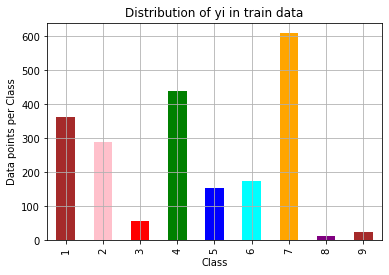

Number of data pts. in class 7  :  609 ( 28.672 %)
Number of data pts. in class 4  :  439 ( 20.669 %)
Number of data pts. in class 1  :  363 ( 17.09 %)
Number of data pts. in class 2  :  289 ( 13.606 %)
Number of data pts. in class 6  :  176 ( 8.286 %)
Number of data pts. in class 5  :  155 ( 7.298 %)
Number of data pts. in class 3  :  57 ( 2.684 %)
Number of data pts. in class 9  :  24 ( 1.13 %)
Number of data pts. in class 8  :  12 ( 0.565 %)


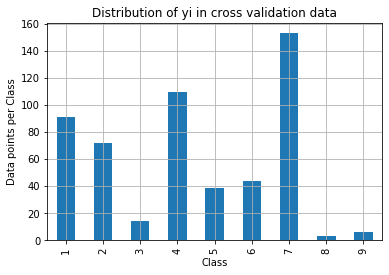

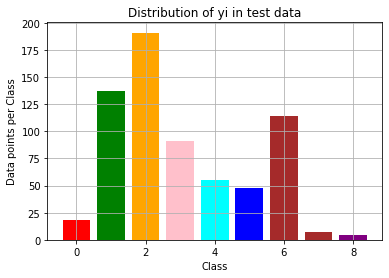

In [18]:
# Class labels as keys and number of data points as values
train_class_distribution=train_df['Class'].value_counts().sort_index()
cv_class_distribution=cv_df['Class'].value_counts().sort_index()
test_class_distribution=test_df['Class'].value_counts().sort_index()


my_colors = ['brown','pink', 'red', 'green', 'blue', 'cyan','orange','purple']
train_class_distribution.plot(kind='bar',color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

sorted_yi=np.argsort(-train_class_distribution.values) #keys in ascending 
for i in sorted_yi:
    print("Number of data pts. in class",i+1, ' : ', train_class_distribution.values[i],'(',np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3),'%)')
    
    
    
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross validation data')
plt.grid()
plt.show()


plt.bar(sorted_yi,test_class_distribution.values,color=my_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

* Training and Text data have a similar distribution,which is good but class imbalance is there.

# Making of a Random model -(Behind the scenes :)

In [19]:
# function to plot confusion matrix
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(test_y,predict_y):
    C=confusion_matrix(test_y,predict_y)
    
    Precissions=(((C.T)/C.sum(axis=1)).T) #axis=1 means column 
    Recalls =(C/C.sum(axis=0))
    #divide each element of the confusion matrix with the sum of elements in that row
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(Precissions, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(Recalls, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    

In [20]:
from sklearn.metrics.classification import accuracy_score, log_loss

Log loss on Cross Validation Data using Random Model 2.5171141809890147
Log loss on Test Data using Random Model 2.5644975738820377
-------------------- Confusion matrix --------------------


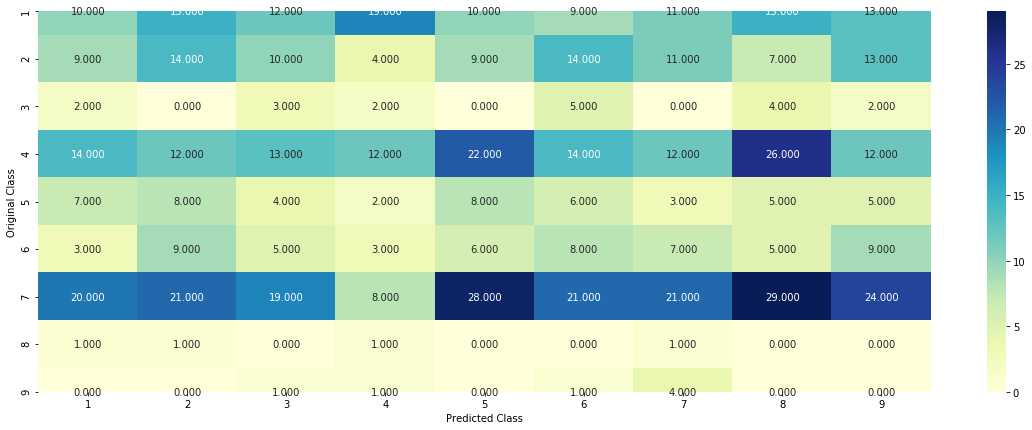

-------------------- Precision matrix (Columm Sum=1) --------------------


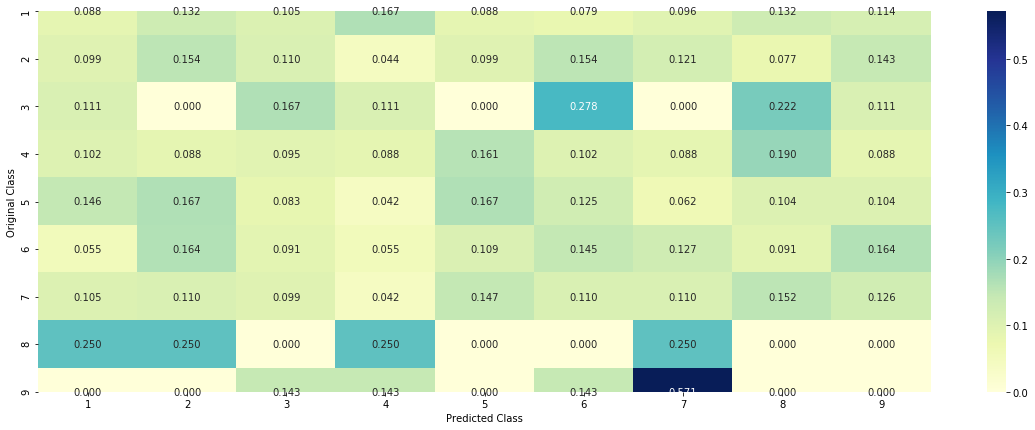

-------------------- Recall matrix (Row sum=1) --------------------


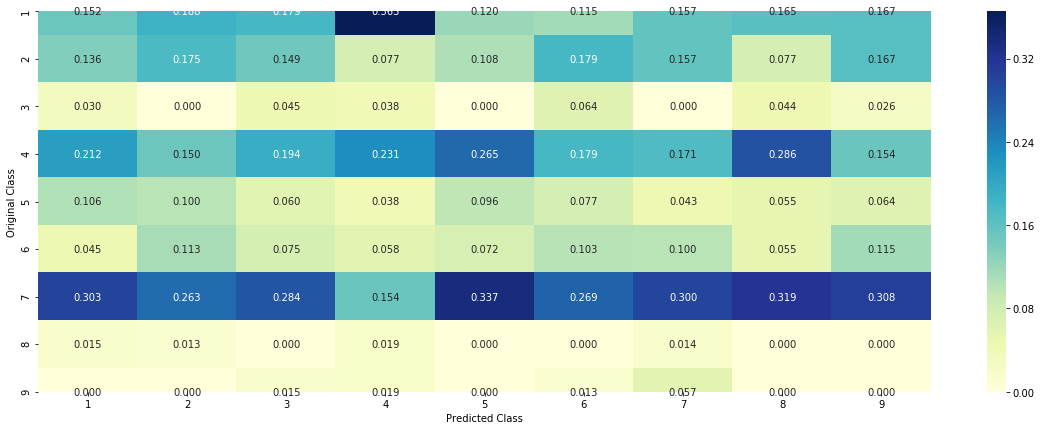

In [21]:
test_data_len = test_df.shape[0]
cv_data_len = cv_df.shape[0]

cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<font color="purple" size=4> Ideally we want diagonal elements to be very large,in all 3 models
     - For precission metrix,Of all the predicted x z% of them actual belong to class y
    - For recall metrix,of all actual x class z% is predicted y%
    
    

# Univariate Analysis

In [22]:
# code for response coding with Laplace smoothing.
# alpha : used for laplace smoothing
# feature: ['gene', 'variation']
# df: ['train_df', 'test_df', 'cv_df']

# algorithm
# ----------
# Consider all unique values and the number of occurances of given feature in train data dataframe
# build a vector (1*9) , the first element = (number of times it occured in class1 + 10*alpha / number of time it occurred in total data+10*9*alpha)
# gv_dict is like a look up table, for every gene it store a (1*9) representation of it
# for a value of feature in df:
# if it is in train data:
# we add the vector that was stored in 'gv_dict' look up table to 'gv_fea'
# if it is not there is train:
# we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
# return 'gv_fea'
# ----------------------

def get_gv_fea_dict(alpha,feature,df):
    value_count=train_df[feature].value_counts()
    #remeber never never use cv,test, called response leakage
    print("up value_count is",value_count)
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene/variation
    gv_dict = dict()
    # denominator will contain the number of time that particular feature occured in whole data
    for i, denominator in value_count.items():
        vec=[]
        print("up i is",i)
        print("up deno is",denominator)
        for k in range(1,10):
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
        gv_dict[i]=vec
    return gv_dict


def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    value_count = train_df[feature].value_counts()
    gv_fea = []
    
    for index, row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            print("down this appending",gv_dict[row[feature]])
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])#np.ones(9)/9
        
    return gv_fea
    

# Univariate Analysis

<p style="font-size:18px;"> <b>Q1.</b> Gene, What type of feature it is ?</p>
<p style="font-size:16px;"><b>Ans.</b> Gene is a categorical variable </p>
<p style="font-size:18px;"> <b>Q2.</b> How many categories are there and How they are distributed?</p>

In [23]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 236
BRCA1     176
TP53      108
EGFR       92
BRCA2      83
PTEN       80
BRAF       60
KIT        57
ERBB2      52
ALK        50
PDGFRA     42
Name: Gene, dtype: int64


In [24]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 236 different categories of genes in the train data, and they are distibuted as follows


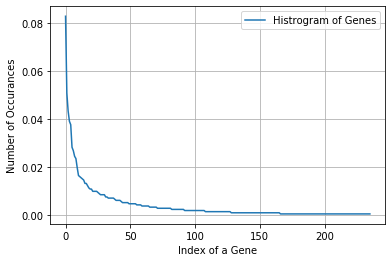

In [25]:
s = sum(unique_genes.values);
h = unique_genes.values/s;  # Element wise operation ,So we get a vector
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


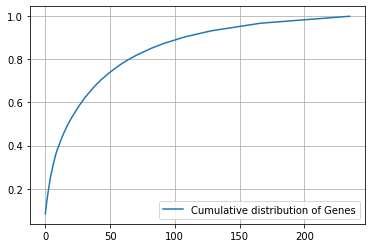

In [26]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()
#Just the top 50 contributes to 75% of data.

<p style="font-size:18px;"> <b>Q3.</b> How to featurize this Gene feature ?</p>

<p style="font-size:16px;"><b>Ans.</b>there are two ways we can featurize this variable
check out this video: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/
<ol><li>One hot Encoding</li><li>Response coding For every gene-i  converting to vector of probablities P(y=j| gene-i) e.g. here vector of length 9. 0,0,0.2,0,0.7,0.1,0,</li></ol></p>
<p> We will choose the appropriate featurization based on the ML model we use.  For this problem of multi-class classification with categorical features, one-hot encoding is better for Logistic regression while response coding should work better for Random Forests(but not!). </p>

In [27]:
#response-coding of the Gene feature
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))


up value_count is BRCA1    176
TP53     108
EGFR      92
BRCA2     83
PTEN      80
        ... 
ATR        1
GNA11      1
RAB35      1
BCL2       1
PRDM1      1
Name: Gene, Length: 236, dtype: int64
up i is BRCA1
up deno is 176
up i is TP53
up deno is 108
up i is EGFR
up deno is 92
up i is BRCA2
up deno is 83
up i is PTEN
up deno is 80
up i is BRAF
up deno is 60
up i is KIT
up deno is 57
up i is ERBB2
up deno is 52
up i is ALK
up deno is 50
up i is PDGFRA
up deno is 42
up i is FLT3
up deno is 35
up i is TSC2
up deno is 34
up i is PIK3CA
up deno is 33
up i is FGFR2
up deno is 32
up i is CDKN2A
up deno is 31
up i is VHL
up deno is 28
up i is MLH1
up deno is 28
up i is MAP2K1
up deno is 26
up i is MTOR
up deno is 24
up i is RET
up deno is 23
up i is KRAS
up deno is 23
up i is ABL1
up deno is 21
up i is MET
up deno is 21
up i is SMAD4
up deno is 21
up i is JAK2
up deno is 21
up i is AKT1
up deno is 20
up i is FGFR3
up deno is 19
up i is ROS1
up deno is 18
up i is NOTCH1
up deno is 18
up i 

down this appending [0.1326530612244898, 0.10204081632653061, 0.11224489795918367, 0.12244897959183673, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.12380952380952381, 0.09523809523809523, 0.09523809523809523, 0.2, 0.10476190476190476, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.055555

down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.09009009009009009, 0.26126126126126126, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.10810810810810811, 0.09009009009009009, 0.09009009009009009]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.125, 0.10416666666666667, 0.10416666666666667, 0.14583333333333334, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.08849557522123894, 0.1415929203539823, 0.08849557522123894, 0.11504424778761062, 0.11504424778761062, 0.08849557522123894, 0.18584070796460178, 0.08

down this appending [0.12380952380952381, 0.09523809523809523, 0.09523809523809523, 0.2, 0.10476190476190476, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523]
down this appending [0.1368421052631579, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.11578947368421053, 0.11578947368421053, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.07746478873239436, 0.14788732394366197, 0.07042253521126761, 0.1056338028169014, 0.09154929577464789, 0.15492957746478872, 0.20422535211267606, 0.0774647887

down this appending [0.17475728155339806, 0.0970873786407767, 0.0970873786407767, 0.10679611650485436, 0.10679611650485436, 0.1262135922330097, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767]
down this appending [0.09174311926605505, 0.11009174311926606, 0.09174311926605505, 0.09174311926605505, 0.14678899082568808, 0.09174311926605505, 0.1926605504587156, 0.09174311926605505, 0.09174311926605505]
down this appending [0.20967741935483872, 0.08064516129032258, 0.08064516129032258, 0.21774193548387097, 0.08064516129032258, 0.08064516129032258, 0.08870967741935484, 0.08064516129032258, 0.08064516129032258]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.07746478873239436, 0.14788732394366197, 0.07042253521126761, 0.1056338028169014, 0.09154929577464789, 0.15492957746478872, 0.20422535211267606, 0

down this appending [0.09433962264150944, 0.10377358490566038, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.2358490566037736, 0.09433962264150944, 0.09433962264150944]
down this appending [0.11956521739130435, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.11956521739130435]
down this appending [0.08771929824561403, 0.12280701754385964, 0.15789473684210525, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.19298245614035087, 0.08771929824561403, 0.08771929824561403]
down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.0555555555555555

down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.13043478260869565, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.13, 0.1, 0.1, 0.14, 0.13, 0.1, 0.1, 0.1, 0.1]
down this appending [0.09900990099009901, 0.15841584158415842, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901, 0.10891089108910891, 0.13861386138613863, 0.09900990099009901, 0.09900990099009901]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142

down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.11538461538461539, 0.09615384615384616, 0.09615384615384616, 0.21153846153846154, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616]
down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.07575757575757576, 0.09090909090909091, 0.12121212121212122, 0.08333333333333333, 0.09848484848484848, 0.07575757575757576, 0.30303030303030304, 0.07575757575757576, 0.07575757575757576]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.0884955752212389

down this appending [0.125, 0.10416666666666667, 0.10416666666666667, 0.14583333333333334, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.16326530612244897, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12631578947368421, 0.10526315789473684, 0.10526315789473684, 0.12631578947368421, 0.11578947368421053, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684]
down this appending [0.15254237288135594, 0.0847457627118644, 0.0847457627118644, 0.2288135593220339, 0.1016949152542373, 0.09322033898305085, 0.0847457627118644, 0.084745762

down this appending [0.11827956989247312, 0.11827956989247312, 0.10752688172043011, 0.10752688172043011, 0.11827956989247312, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.08620689655172414, 0.13793103448275862, 0.08620689655172414, 0.09482758620689655, 0.10344827586206896, 0.11206896551724138, 0.20689655172413793, 0.08620689655172414, 0.08620689655172414]
down this appending [0.13, 0.1, 0.1, 0.14, 0.13, 0.1, 0.1, 0.1, 0.1]
down this appending [0.09259259259259259, 0.16666666666666666, 0.09259259259259259, 0.0

down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1]
down this appending [0.09523809523809523, 0.12380952380952381, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.20952380952380953, 0.09523809523809523, 0.09523809523809523]
down this appending [0.11475409836065574, 0.10655737704918032, 0.08196721311475409, 0.08196721311475409, 0.12295081967213115, 0.09836065573770492, 0.22950819672131148, 0.08196721311475409, 0.08196721311475409]
down this appending [0.16216216216216217, 0.09009009009009009, 0.09009009009009009, 0.16216216216216217, 0.10810810810810811, 0.11711711711711711, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009]
down this appending [0.15254237288135594, 0.0847457627118644, 0.0847457627118644, 0.135593

down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.08849557522123894]
down this appending [0.10752688172043011, 0.11827956989247312, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011, 0.12903225806451613, 0.10752688172043011, 0.10752688172043011]
down this appending [0.09090909090909091, 0.10909090909090909, 0.1, 0.09090909090909091, 0.10909090909090909, 0.09090909090909091, 0.21818181818181817, 0.1, 0.09090909090909091]
down this appending [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1]
down this appending [0.09090909090909091, 0.10909090909090909, 0.1, 0.09090909090909091, 0.10909090909090909, 0.09090909090909091, 0.21818181818181817, 0.1, 0.09090909090909091]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.109890109

down this appending [0.09803921568627451, 0.10784313725490197, 0.11764705882352941, 0.09803921568627451, 0.09803921568627451, 0.12745098039215685, 0.1568627450980392, 0.09803921568627451, 0.09803921568627451]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.09259259259259259, 0.16666666666666666, 0.09259259259259259, 0.09259259259259259, 0.10185185185185185, 0.09259259259259259, 0.17592592592592593, 0.09259259259259259, 0.09259259259259259]
down this appending [0.10743801652892562, 0.08264462809917356, 0.08264462809917356, 0.3140495867768595, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.

down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.12371134020618557, 0.10309278350515463, 0.15463917525773196]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.10204081632653061, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.16326530612244897, 0.10204081632653061, 0.10204081632653061]
down this appending [0.07746478873239436, 0.14788732394366197, 0.07042253521126761, 0.1056338028169014, 0.09154929577464789, 0.15492957746478872, 0.20422535

down this appending [0.07142857142857142, 0.08571428571428572, 0.1357142857142857, 0.07142857142857142, 0.1, 0.07142857142857142, 0.32142857142857145, 0.07142857142857142, 0.07142857142857142]
down this appending [0.08771929824561403, 0.12280701754385964, 0.15789473684210525, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.19298245614035087, 0.08771929824561403, 0.08771929824561403]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.0375939

down this appending [0.13131313131313133, 0.10101010101010101, 0.1111111111111111, 0.1414141414141414, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101]
down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.08849557522123894]
down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
d

down this appending [0.10416666666666667, 0.11458333333333333, 0.10416666666666667, 0.13541666666666666, 0.10416666666666667, 0.10416666666666667, 0.125, 0.10416666666666667, 0.10416666666666667]
down this appending [0.11538461538461539, 0.09615384615384616, 0.09615384615384616, 0.21153846153846154, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.08849557522123894]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.12631578947368421, 0.10526315789473684, 0.11578947368421053, 0.11578947368421053, 0.10526315789473684, 0.10526315789473684, 0.11578947368421053, 0.105

down this appending [0.09523809523809523, 0.12380952380952381, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.20952380952380953, 0.09523809523809523, 0.09523809523809523]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.07142857142857142, 0.08571428571428572, 0.1357142857142857, 0.07142857142857142, 0.1, 0.07142857142857142, 0.32142857142857145, 0.07142857142857142, 0.07142857142857142]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.09803921568627451, 0.10784313725490197, 0.11764705882352941, 0.09803921568627451, 0.09803921568627451, 0.12745098039215685, 0.1568627450980392, 0.09803

down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.09009009009009009, 0.26126126126126126, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.10810810810810811, 0.09009009009009009, 0.09009009009009009]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.0

down this appending [0.16216216216216217, 0.09009009009009009, 0.09009009009009009, 0.16216216216216217, 0.10810810810810811, 0.11711711711711711, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009]
down this appending [0.20967741935483872, 0.08064516129032258, 0.08064516129032258, 0.21774193548387097, 0.08064516129032258, 0.08064516129032258, 0.08870967741935484, 0.08064516129032258, 0.08064516129032258]
down this appending [0.09009009009009009, 0.13513513513513514, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.0990990990990991, 0.22522522522522523, 0.09009009009009009, 0.09009009009009009]
down this appending [0.09009009009009009, 0.26126126126126126, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.10810810810810811, 0.09009009009009009, 0.09009009009009009]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.0375939849624

down this appending [0.08, 0.104, 0.128, 0.08, 0.08, 0.08, 0.288, 0.08, 0.08]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.07746478873239436, 0.14788732394366197, 0.07042253521126761, 0.1056338028169014, 0.09154929577464789, 0.15492957746478872, 0.20422535211267606, 0.07746478873239436, 0.07042253521126761]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411

down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.15625, 0.11458333333333333, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.10869565217391304, 0.11956521739130435, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.11956521739130435, 0.10869565217391304, 0.10869565217391304]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.11827956989247312, 0.10752688172043011, 0.10752688172043011, 0.11827956989247312, 0.10752688172043011, 0.11827956989247312, 0.10752688172043011, 0.10752688172

down this appending [0.08771929824561403, 0.12280701754385964, 0.15789473684210525, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.19298245614035087, 0.08771929824561403, 0.08771929824561403]
down this appending [0.15254237288135594, 0.0847457627118644, 0.0847457627118644, 0.2288135593220339, 0.1016949152542373, 0.09322033898305085, 0.0847457627118644, 0.0847457627118644, 0.0847457627118644]
down this appending [0.10526315789473684, 0.11578947368421053, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.11578947368421053, 0.1368421052631579, 0.10526315789473684, 0.10526315789473684]
down this appending [0.1523809523809524, 0.09523809523809523, 0.10476190476190476, 0.17142857142857143, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523]
down this appending [0.10204081632653061, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.16326530612244897, 0

down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.20967741935483872, 0.08064516129032258, 0.08064516129032258, 0.21774193548387097, 0.08064516129032258, 0.08064516129032258, 0.08870967741935484, 0.08064516129032258, 0.08064516129032258]
down this appending [0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.16666666666666666, 0.10416666666666667, 0.10416666666666667]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240

down this appending [0.09009009009009009, 0.12612612612612611, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.14414414414414414, 0.1891891891891892, 0.09009009009009009, 0.09009009009009009]
down this appending [0.09900990099009901, 0.15841584158415842, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901, 0.10891089108910891, 0.13861386138613863, 0.09900990099009901, 0.09900990099009901]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.07575757575757576, 0.09090909090909091, 0.12121212121212122, 0.08333333333333333, 0.09848484848484848, 0.07575757575757576, 0.30303030303030304, 0.07575757575757576, 0.07575757575757576]
down this appending [0.07746478873239436, 0.14788732394366197, 0.07042253521126761, 0.1056338028169014, 0.09154929577464789, 0.15492957746478872, 0.20422535211267

down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.07142857142857142, 0.08571428571428572, 0.1357142857142857, 0.07142857142857142, 0.1, 0.07142857142857142, 0.32142857142857145, 0.07142857142857142, 0.07142857142857142]
down this appending [0.09433962264150944, 0.10377358490566038, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.09433962264150944, 0.2358490566037736, 0.09433962264150944, 0.09433962264150944]
down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.11702127659574468, 0.11702127659574468, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426]
down this appen

down this appending [0.125, 0.10416666666666667, 0.10416666666666667, 0.13541666666666666, 0.11458333333333333, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.11, 0.11, 0.1, 0.1, 0.11, 0.1, 0.17, 0.1, 0.1]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.07575757575757576, 0.09090909090909091, 0.12121212121212122, 0.08333333333333333, 0.09848484848484848, 0.07575757575757576, 0.30303030303030304, 0.07575757575757576, 0.07575757575757576]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 

down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.12871287128712872, 0.09900990099009901, 0.09900990099009901, 0.10891089108910891, 0.12871287128712872, 0.13861386138613863, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901]
down this appending [0.07575757575757576, 0.09090909090909091, 0.12121212121212122, 0.08333333333333333, 0.09848484848484848, 0.07575757575757576, 0.30303030303030304, 0.07575757575757576, 0.07575757575757576]
down this appending [0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.13829787234042554, 0.10638297872340426, 0.11702127659574468]
down this appending [0.08, 0.104, 0.128, 0.08, 0.08, 0.08, 0.288, 0.08, 0.08]
down this appending [0.10752688172043011, 0.10752688172043011, 0.1075268817204301

down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.13131313131313133, 0.10101010101010101, 0.1111111111111111, 0.1414141414141414, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529

down this appending [0.07142857142857142, 0.08571428571428572, 0.1357142857142857, 0.07142857142857142, 0.1, 0.07142857142857142, 0.32142857142857145, 0.07142857142857142, 0.07142857142857142]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.08849557522123894]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.16666666666666666, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.11475409836065574, 0.10655737704918032, 0.08196721311475409, 0.08196721311475409, 0.12295081967213115, 0.09836065573770492, 0.22950819672131148, 0.08196721

down this appending [0.12, 0.1, 0.1, 0.18, 0.1, 0.1, 0.1, 0.1, 0.1]
down this appending [0.16494845360824742, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.1134020618556701, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463]
down this appending [0.07142857142857142, 0.08571428571428572, 0.1357142857142857, 0.07142857142857142, 0.1, 0.07142857142857142, 0.32142857142857145, 0.07142857142857142, 0.07142857142857142]
down this appending [0.11320754716981132, 0.09433962264150944, 0.09433962264150944, 0.20754716981132076, 0.09433962264150944, 0.09433962264150944, 0.11320754716981132, 0.09433962264150944, 0.09433962264150944]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173,

down this appending [0.08849557522123894, 0.1415929203539823, 0.08849557522123894, 0.11504424778761062, 0.11504424778761062, 0.08849557522123894, 0.18584070796460178, 0.08849557522123894, 0.08849557522123894]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.09174311926605505, 0.11009174311926606, 0.09174311926605505, 0.09174311926605505, 0.14678899082568808, 0.09174311926605505, 0.1926605504587156, 0.09174311926605505, 0.09174311926605505]
down this appending [0.09174311926605505, 0.11009174311926606, 0.09174311926605505, 0.09174311926605505, 0.14678899082568808, 0.09174311926605505, 0.1926605504587156, 0.09174311926605505, 0.09174311926605505]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.0375

down this appending [0.125, 0.10416666666666667, 0.10416666666666667, 0.13541666666666666, 0.11458333333333333, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.10743801652892562, 0.08264462809917356, 0.08264462809917356, 0.3140495867768595, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this appending [0.10743801652892562, 0.08264462809917356, 0.08264462809917356, 0.3140495867768595, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356]
down this appending [0.13131313131313133, 0.10101010101010101, 0.1111111111111111, 0.1414141414141414, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.101010101

down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10416666666666667, 0.125, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.14583333333333334, 0.10416666666666667, 0.10416666666666667]
down this appending [0.09009009009009009, 0.13513513513513514, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.0990990990990991, 0.22522522522522523, 0.09009009009009009, 0.09009009009009009]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.0

down this appending [0.11956521739130435, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.11956521739130435, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.12903225806451613, 0.11827956989247312, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011, 0.10752688172043011,

down this appending [0.10416666666666667, 0.11458333333333333, 0.10416666666666667, 0.13541666666666666, 0.10416666666666667, 0.10416666666666667, 0.125, 0.10416666666666667, 0.10416666666666667]
down this appending [0.15254237288135594, 0.0847457627118644, 0.0847457627118644, 0.2288135593220339, 0.1016949152542373, 0.09322033898305085, 0.0847457627118644, 0.0847457627118644, 0.0847457627118644]
down this appending [0.11538461538461539, 0.09615384615384616, 0.09615384615384616, 0.21153846153846154, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616, 0.09615384615384616]
down this appending [0.12871287128712872, 0.09900990099009901, 0.09900990099009901, 0.10891089108910891, 0.12871287128712872, 0.13861386138613863, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901]
down this appending [0.08, 0.104, 0.128, 0.08, 0.08, 0.08, 0.288, 0.08, 0.08]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.063583815028901

In [28]:
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
# cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

up value_count is BRCA1    176
TP53     108
EGFR      92
BRCA2     83
PTEN      80
        ... 
ATR        1
GNA11      1
RAB35      1
BCL2       1
PRDM1      1
Name: Gene, Length: 236, dtype: int64
up i is BRCA1
up deno is 176
up i is TP53
up deno is 108
up i is EGFR
up deno is 92
up i is BRCA2
up deno is 83
up i is PTEN
up deno is 80
up i is BRAF
up deno is 60
up i is KIT
up deno is 57
up i is ERBB2
up deno is 52
up i is ALK
up deno is 50
up i is PDGFRA
up deno is 42
up i is FLT3
up deno is 35
up i is TSC2
up deno is 34
up i is PIK3CA
up deno is 33
up i is FGFR2
up deno is 32
up i is CDKN2A
up deno is 31
up i is VHL
up deno is 28
up i is MLH1
up deno is 28
up i is MAP2K1
up deno is 26
up i is MTOR
up deno is 24
up i is RET
up deno is 23
up i is KRAS
up deno is 23
up i is ABL1
up deno is 21
up i is MET
up deno is 21
up i is SMAD4
up deno is 21
up i is JAK2
up deno is 21
up i is AKT1
up deno is 20
up i is FGFR3
up deno is 19
up i is ROS1
up deno is 18
up i is NOTCH1
up deno is 18
up i 

down this appending [0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.1134020618556701, 0.13402061855670103, 0.10309278350515463, 0.10309278350515463, 0.1134020618556701, 0.12371134020618557]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.1326530612244898, 0.10204081632653061, 0.11224489795918367, 0.12244897959183673, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484,

down this appending [0.09009009009009009, 0.12612612612612611, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.14414414414414414, 0.1891891891891892, 0.09009009009009009, 0.09009009009009009]
down this appending [0.07575757575757576, 0.09090909090909091, 0.12121212121212122, 0.08333333333333333, 0.09848484848484848, 0.07575757575757576, 0.30303030303030304, 0.07575757575757576, 0.07575757575757576]
down this appending [0.20967741935483872, 0.08064516129032258, 0.08064516129032258, 0.21774193548387097, 0.08064516129032258, 0.08064516129032258, 0.08870967741935484, 0.08064516129032258, 0.08064516129032258]
down this appending [0.13131313131313133, 0.10101010101010101, 0.1111111111111111, 0.1414141414141414, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101]
down this appending [0.11475409836065574, 0.10655737704918032, 0.08196721311475409, 0.08196721311475409, 0.12295081967213115, 0.09836065573770492, 0.229508196721311

down this appending [0.11, 0.1, 0.1, 0.1, 0.11, 0.12, 0.16, 0.1, 0.1]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.11650485436893204, 0.0970873786407767, 0.14563106796116504, 0.1553398058252427, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10752688172043011, 0.11827956989247312, 0.10752688172043011, 0.10752688172043011, 0.1

down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0.1]
down this appending [0.11578947368421053, 0.10526315789473684, 0.10526315789473684, 0.14736842105263157, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684]
down this appending [0.1523809523809524, 0.09523809523809523, 0.10476190476190476, 0.17142857142857143, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523]
down this appending [0.11, 0.1, 0.1, 0.1, 0.11, 0.12, 0.16, 0.1, 0.1]
down this appending [0.07647058823

down this appending [0.10101010101010101, 0.12121212121212122, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.16161616161616163, 0.10101010101010101, 0.10101010101010101]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.08849557522123894]
down this appending [0.09803921568627451, 0.10784313725490197, 0.11764705882352941, 0.09803921568627451, 0.09803921568627451, 0.12745098039215685, 0.1568627450980392, 0.09803921568627451, 0.09803921568627451]
down this appending [0.08, 0.104, 0.128, 0.08, 0.08, 0.08, 0.288, 0.08, 0.08]
down this appending [0.12121212121212122, 0.10101010101010101, 0.10101010101010101, 0.1717171717171717, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101]
down this appending [0.08620689655172414, 0.13793103448275862, 0.08620689655172414, 0

down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.10204081632653061, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.16326530612244897, 0.10204081632653061, 0.10204081632653061]
down this appending [0.10416666666666667, 0.125, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.14583333333333334, 0.10416666666666667, 0.10416666666666667]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.07142857142857142, 0.08571428571428572, 0.1357142857142857, 0.07142857142857142, 0.1, 0.07142857142857142, 0.32142857142857145, 0.07142857142857142,

down this appending [0.08771929824561403, 0.12280701754385964, 0.15789473684210525, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.19298245614035087, 0.08771929824561403, 0.08771929824561403]
down this appending [0.09259259259259259, 0.16666666666666666, 0.09259259259259259, 0.09259259259259259, 0.10185185185185185, 0.09259259259259259, 0.17592592592592593, 0.09259259259259259, 0.09259259259259259]
down this appending [0.125, 0.10416666666666667, 0.10416666666666667, 0.13541666666666666, 0.11458333333333333, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667]
down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.13043478260869565, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this 

down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.12371134020618557, 0.10309278350515463, 0.15463917525773196]
down this appending [0.08849557522123894, 0.12389380530973451, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.08849557522123894, 0.25663716814159293, 0.08849557522123894, 0.08849557522123894]
down this appending [0.09009009009009009, 0.13513513513513514, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.0990990990990991, 0.22522522522522523, 0.09009009009009009, 0.09009009009009009]
down this appending [0.11538461538461539, 0.09615384615384616, 0.09615384615384616, 0.21153846153846154, 0.09615384615384616, 0.09615384615384616, 0.09615384

down this appending [0.10309278350515463, 0.10309278350515463, 0.10309278350515463, 0.1134020618556701, 0.13402061855670103, 0.10309278350515463, 0.10309278350515463, 0.1134020618556701, 0.12371134020618557]
down this appending [0.12, 0.1, 0.1, 0.18, 0.1, 0.1, 0.1, 0.1, 0.1]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.10891089108910891, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901, 0.09900990099009901, 0.19801980198019803, 0.09900990099009901, 0.09900990099009901]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.063583

down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.10101010101010101, 0.12121212121212122, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.16161616161616163, 0.10101010101010101, 0.10101010101010101]
down this appending [0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.13829787234042554, 0.10638297872340426, 0.11702127659574468]
down this appending [0.07575757575757576, 0.09090909090909091, 0.12121212121212122, 0.08333333333333333, 0.09848484848484848, 0.07575757575757576, 0.30303030303030304, 0.07575757575757576, 0.07575757575757576]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.1304347826086

down this appending [0.11650485436893204, 0.1553398058252427, 0.0970873786407767, 0.10679611650485436, 0.0970873786407767, 0.11650485436893204, 0.11650485436893204, 0.0970873786407767, 0.0970873786407767]
down this appending [0.11702127659574468, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.1276595744680851, 0.11702127659574468, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426]
down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.10743801652892562, 0.08264462809917356, 0.08264462809917356, 0.3140495867768595, 0.08264462809917356, 0.08264462809917356, 0.08264462809917356, 0

up i is PTPRT
up deno is 13
up i is SMAD2
up deno is 13
up i is PDGFRB
up deno is 13
up i is TSC1
up deno is 13
up i is ERBB4
up deno is 12
up i is SF3B1
up deno is 11
up i is SMO
up deno is 11
up i is JAK1
up deno is 11
up i is TET2
up deno is 11
up i is RHOA
up deno is 11
up i is AR
up deno is 10
up i is FGFR1
up deno is 10
up i is KEAP1
up deno is 10
up i is NF1
up deno is 10
up i is CTNNB1
up deno is 10
up i is MSH6
up deno is 10
up i is EWSR1
up deno is 9
up i is ESR1
up deno is 9
up i is SPOP
up deno is 9
up i is FBXW7
up deno is 9
up i is EP300
up deno is 8
up i is PMS2
up deno is 8
up i is RAF1
up deno is 8
up i is ERBB3
up deno is 8
up i is TGFBR1
up deno is 8
up i is CCND1
up deno is 8
up i is POLE
up deno is 7
up i is PIK3CB
up deno is 7
up i is EZH2
up deno is 7
up i is PPP2R1A
up deno is 7
up i is STK11
up deno is 7
up i is IDH1
up deno is 7
up i is TERT
up deno is 6
up i is CHEK2
up deno is 6
up i is FOXA1
up deno is 6
up i is STAT3
up deno is 6
up i is ETV6
up deno is 6


down this appending [0.08620689655172414, 0.13793103448275862, 0.08620689655172414, 0.09482758620689655, 0.10344827586206896, 0.11206896551724138, 0.20689655172413793, 0.08620689655172414, 0.08620689655172414]
down this appending [0.07746478873239436, 0.14788732394366197, 0.07042253521126761, 0.1056338028169014, 0.09154929577464789, 0.15492957746478872, 0.20422535211267606, 0.07746478873239436, 0.07042253521126761]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.09174311926605505, 0.11009174311926606, 0.09174311926605505, 0.09174311926605505, 0.14678899082568808, 0.09174311926605505, 0.1926605504587156, 0.09174311926605505, 0.09174311926605505]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.0578034682080

down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.11475409836065574, 0.10655737704918032, 0.08196721311475409, 0.08196721311475409, 0.12295081967213115, 0.09836065573770492, 0.22950819672131148, 0.08196721311475409, 0.08196721311475409]
down this appending [0.17475728155339806, 0.0970873786407767, 0.0970873786407767, 0.10679611650485436, 0.10679611650485436, 0.1262135922330097, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767]
down this appending [0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1]
down this appending [0.12121212121212122, 0.10101010101010101, 0.10101010101010101, 0.1717171717171717, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.0748299319727891

down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.10638297872340426, 0.11702127659574468, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.11702127659574468, 0.1276595744680851, 0.10638297872340426, 0.10638297872340426]
down this appending [0.17475728155339806, 0.0970873786407767, 0.0970873786407767, 0.10679611650485436, 0.10679611650485436, 0.1262135922330097, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.15789473684210525,

down this appending [0.08849557522123894, 0.1415929203539823, 0.08849557522123894, 0.11504424778761062, 0.11504424778761062, 0.08849557522123894, 0.18584070796460178, 0.08849557522123894, 0.08849557522123894]
down this appending [0.10101010101010101, 0.12121212121212122, 0.1111111111111111, 0.10101010101010101, 0.10101010101010101, 0.10101010101010101, 0.16161616161616163, 0.10101010101010101, 0.10101010101010101]
down this appending [0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.109890109890109

down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.20300751879699247, 0.03759398496240601, 0.06766917293233082, 0.12781954887218044, 0.2819548872180451, 0.16917293233082706, 0.03759398496240601, 0.03759398496240601, 0.03759398496240601]
down this appending [0.09009009009009009, 0.13513513513513514, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.0990990990990991, 0.22522522522522523, 0.09009009009009009, 0.09009009009009009]
down this appending [0.11538461538461539, 0.09615384615384616, 0.09615384615384616, 0.21153846153846154, 0.09615384615384616, 0.09615384615384616, 0.09615384615384

down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.06666666666666667, 0.19333333333333333, 0.07333333333333333, 0.07333333333333333, 0.1, 0.08, 0.28, 0.06666666666666667, 0.06666666666666667]
down this appending [0.06043956043956044, 0.2032967032967033, 0.06043956043956044, 0.07142857142857142, 0.06043956043956044, 0.054945054945054944, 0.37362637362637363, 0.06043956043956044, 0.054945054945054944]
down this appending [0.12380952380952381, 0.09523809523809523, 0.09523809523809523, 0.2, 0.10476190476190476, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523, 0.09523809523809523]
down this appending [0.10204081632653061, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.16326530612244897, 0.10204081632653061, 0.10204081632653061]
down this appending [0.07575757575757576, 0.0909090909090

down this appending [0.09174311926605505, 0.11009174311926606, 0.09174311926605505, 0.09174311926605505, 0.14678899082568808, 0.09174311926605505, 0.1926605504587156, 0.09174311926605505, 0.09174311926605505]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.3434343434343434, 0.05555555555555555, 0.05555555555555555, 0.2676767676767677, 0.050505050505050504, 0.0707070707070707, 0.050505050505050504, 0.050505050505050504, 0.05555555555555555]
down this appending [0.11650485436893204, 0.1553398058252427, 0.0970873786407767, 0.10679611650485436, 0.0970873786407767, 0.11650485436893204, 0.11650485436893204, 0.0970873786407767, 0.0970873786407767]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989,

down this appending [0.17475728155339806, 0.0970873786407767, 0.0970873786407767, 0.14563106796116504, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767, 0.0970873786407767]
down this appending [0.12716763005780346, 0.057803468208092484, 0.057803468208092484, 0.06358381502890173, 0.13872832369942195, 0.3815028901734104, 0.057803468208092484, 0.057803468208092484, 0.057803468208092484]
down this appending [0.09009009009009009, 0.13513513513513514, 0.09009009009009009, 0.09009009009009009, 0.09009009009009009, 0.0990990990990991, 0.22522522522522523, 0.09009009009009009, 0.09009009009009009]
down this appending [0.10204081632653061, 0.12244897959183673, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.10204081632653061, 0.16326530612244897, 0.10204081632653061, 0.10204081632653061]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823

down this appending [0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.1276595744680851, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426, 0.10638297872340426]
down this appending [0.07647058823529412, 0.058823529411764705, 0.07058823529411765, 0.5, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705, 0.058823529411764705]
down this appending [0.06802721088435375, 0.25170068027210885, 0.06802721088435375, 0.07482993197278912, 0.06802721088435375, 0.07482993197278912, 0.2585034013605442, 0.06802721088435375, 0.06802721088435375]
down this appending [0.08130081300813008, 0.15447154471544716, 0.08130081300813008, 0.08130081300813008, 0.10569105691056911, 0.0975609756097561, 0.23577235772357724, 0.08130081300813008, 0.08130081300813008]
down this appending [0.08849557522123894, 0.1415929203539823, 0.08849557522123894, 0.11504424778761062, 0.11504424778761062, 0.08849557522123894, 0.18584070796460178, 0.08849

In [29]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [31]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1a',
 'arid1b',
 'arid2',
 'atm',
 'atr',
 'atrx',
 'aurka',
 'aurkb',
 'axin1',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cebpa',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'errfi1',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fancc',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt3',
 'foxa1',
 'foxo1',
 'fubp1',
 'gata3',
 'gna11',
 'gnaq',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'ikzf1',
 'il7r',
 'inpp4

In [32]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 236)


<p style="font-size:18px;"> <b>Q4.</b> How good is this gene feature  in predicting y_i?</p>

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2202201076139498
For values of alpha =  0.0001 The log loss is: 1.2153177720896688
For values of alpha =  0.001 The log loss is: 1.2711010356249266
For values of alpha =  0.01 The log loss is: 1.3897627501337906
For values of alpha =  0.1 The log loss is: 1.4789779149566895
For values of alpha =  1 The log loss is: 1.5179028715078715


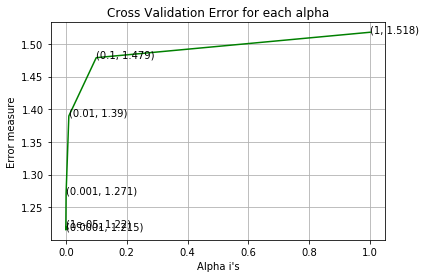

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV


alpha = [10 ** x for x in range(-5, 1)] # hyperparam for SGD classifier.

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    #loss='log' makes it logistic regression
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    # Calibrated classifiers to get nice probablities
    
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()




In [34]:
best_alpha = np.argmin(cv_log_error_array)
print("Best alpha's index",best_alpha)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


Best alpha's index 1
For values of best alpha =  0.0001 The train log loss is: 0.9859165227428612
For values of best alpha =  0.0001 The cross validation log loss is: 1.2153177720896688
For values of best alpha =  0.0001 The test log loss is: 1.2259290962484868


* Since log_loss of gene=1.25<Random's 2.5 hence it is very useful

<p style="font-size:18px;"> <b>Q5.</b> Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?
Do it after Train test</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error. </p>

In [35]:
print("Q6. How many data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset?")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q6. How many data points in Test and CV datasets are covered by the  236  genes in train dataset?
Ans
1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 512 out of  532 : 96.2406015037594


<p style="font-size:18px;"> <b>Q7.</b> Variation, What type of feature is it ?</p>
<p style="font-size:16px;"><b>Ans.</b> Variation is a categorical variable </p>
<p style="font-size:18px;"> <b>Q8.</b> How many categories are there?</p>

In [58]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1930
Truncating_Mutations         59
Amplification                49
Deletion                     43
Fusions                      24
Overexpression                5
Promoter_Hypermethylation     2
C618R                         2
K117N                         2
G12C                          2
R173C                         2
Name: Variation, dtype: int64


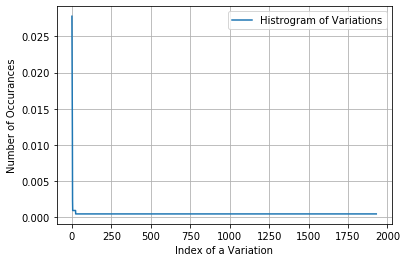

[0.02777778 0.05084746 0.07109228 ... 0.99905838 0.99952919 1.        ]


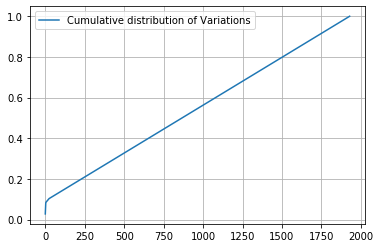

In [60]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()


c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [61]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))

# Response coded data must be done in train only ,response leakage

up value_count is Truncating_Mutations      59
Amplification             49
Deletion                  43
Fusions                   24
Overexpression             5
                          ..
D404G                      1
M133T                      1
T798I                      1
L225LI                     1
W603_E604insDREYEYDLKW     1
Name: Variation, Length: 1930, dtype: int64
up i is Truncating_Mutations
up deno is 59
up i is Amplification
up deno is 49
up i is Deletion
up deno is 43
up i is Fusions
up deno is 24
up i is Overexpression
up deno is 5
up i is Promoter_Hypermethylation
up deno is 2
up i is C618R
up deno is 2
up i is K117N
up deno is 2
up i is G12C
up deno is 2
up i is R173C
up deno is 2
up i is M1R
up deno is 2
up i is Q61L
up deno is 2
up i is G67R
up deno is 2
up i is Q209L
up deno is 2
up i is Y42C
up deno is 2
up i is E17K
up deno is 2
up i is Q61K
up deno is 2
up i is G12A
up deno is 2
up i is G13V
up deno is 2
up i is Y64A
up deno is 2
up i is G13C
up deno is 2
up 

up i is P44A
up deno is 1
up i is R306S
up deno is 1
up i is P114S
up deno is 1
up i is 256_286trunc
up deno is 1
up i is FGFR2-TACC3_Fusion
up deno is 1
up i is S1088F
up deno is 1
up i is Y375_K455del
up deno is 1
up i is SEC16A1-NOTCH1_Fusion
up deno is 1
up i is G1763V
up deno is 1
up i is I33del
up deno is 1
up i is P219S
up deno is 1
up i is G469V
up deno is 1
up i is L493P
up deno is 1
up i is CUL1-BRAF_Fusion
up deno is 1
up i is L321A
up deno is 1
up i is G325A
up deno is 1
up i is E135K
up deno is 1
up i is R130K
up deno is 1
up i is M587V
up deno is 1
up i is Q510E
up deno is 1
up i is R108H
up deno is 1
up i is Y599_D600insSTDNEYFYVDFREYEY
up deno is 1
up i is K428A
up deno is 1
up i is F317L
up deno is 1
up i is K700E
up deno is 1
up i is P531A
up deno is 1
up i is L1224F
up deno is 1
up i is S196N
up deno is 1
up i is D84Y
up deno is 1
up i is S37F
up deno is 1
up i is H168R
up deno is 1
up i is FGFR2-BICC1_Fusion
up deno is 1
up i is R976H
up deno is 1
up i is E81K
up de

up i is N1100Y
up deno is 1
up i is D595V
up deno is 1
up i is E746_T751delinsVA
up deno is 1
up i is D61N
up deno is 1
up i is D450E
up deno is 1
up i is C1265S
up deno is 1
up i is R80L
up deno is 1
up i is G81D
up deno is 1
up i is V1180L
up deno is 1
up i is S217C
up deno is 1
up i is D1029Y
up deno is 1
up i is D513Y
up deno is 1
up i is TFG-NTRK1_Fusion
up deno is 1
up i is Q546E
up deno is 1
up i is Y353L
up deno is 1
up i is S1301R
up deno is 1
up i is R183G
up deno is 1
up i is D835del
up deno is 1
up i is L1584R
up deno is 1
up i is V677I
up deno is 1
up i is L485_P490delinsY
up deno is 1
up i is A614D
up deno is 1
up i is R167Q
up deno is 1
up i is L246V
up deno is 1
up i is S2670L
up deno is 1
up i is A750_E758del
up deno is 1
up i is EZR-ROS1_Fusion
up deno is 1
up i is R80P
up deno is 1
up i is S462Y
up deno is 1
up i is S384F
up deno is 1
up i is W24S
up deno is 1
up i is Q12Y
up deno is 1
up i is I251S
up deno is 1
up i is T630I
up deno is 1
up i is A767_V769dup
up deno

up i is R678Q
up deno is 1
up i is R497H
up deno is 1
up i is E50K
up deno is 1
up i is K753M
up deno is 1
up i is L702H
up deno is 1
up i is W531C
up deno is 1
up i is M1652T
up deno is 1
up i is T1685A
up deno is 1
up i is D83V
up deno is 1
up i is H1620R
up deno is 1
up i is P551_W557delinsL
up deno is 1
up i is P262H
up deno is 1
up i is BCR-PDGFRA_Fusion
up deno is 1
up i is A864T
up deno is 1
up i is S464L
up deno is 1
up i is G751R
up deno is 1
up i is A883F
up deno is 1
up i is S153R
up deno is 1
up i is K120M
up deno is 1
up i is E709Q
up deno is 1
up i is G129E
up deno is 1
up i is V777A
up deno is 1
up i is I834V
up deno is 1
up i is KIF5B-ALK_Fusion
up deno is 1
up i is D493A
up deno is 1
up i is S31R
up deno is 1
up i is N1102Y
up deno is 1
up i is F1592S
up deno is 1
up i is BCAN-NTRK1_Fusion
up deno is 1
up i is KANK1-PDGFRB_Fusion
up deno is 1
up i is V843I
up deno is 1
up i is R249M
up deno is 1
up i is L1301R
up deno is 1
up i is Y510C
up deno is 1
up i is C238S
up de

up deno is 1
up i is E76A
up deno is 1
up i is T47D
up deno is 1
up i is S214T
up deno is 1
up i is E1935G
up deno is 1
up i is L1947R
up deno is 1
up i is R342W
up deno is 1
up i is K607T
up deno is 1
up i is H1106D
up deno is 1
up i is S36Y
up deno is 1
up i is E1250K
up deno is 1
up i is A1830T
up deno is 1
up i is V1809A
up deno is 1
up i is D325A
up deno is 1
up i is C47S
up deno is 1
up i is F57L
up deno is 1
up i is L485_P490del
up deno is 1
up i is A34D
up deno is 1
up i is T82A
up deno is 1
up i is TPR-NTRK1_Fusion
up deno is 1
up i is A750P
up deno is 1
up i is Y163C
up deno is 1
up i is G434R
up deno is 1
up i is R1563S
up deno is 1
up i is ETV6-FLT3_Fusion
up deno is 1
up i is A1708V
up deno is 1
up i is H93Q
up deno is 1
up i is D2512G
up deno is 1
up i is C248T
up deno is 1
up i is RUNX1-RUNX1T1_Fusion
up deno is 1
up i is Y32S
up deno is 1
up i is Y472C
up deno is 1
up i is P1637L
up deno is 1
up i is L64P
up deno is 1
up i is Y3098H
up deno is 1
up i is H1904R
up deno i

up i is R108K
up deno is 1
up i is G831E
up deno is 1
up i is R1076C
up deno is 1
up i is G244R
up deno is 1
up i is Y537S
up deno is 1
up i is L230P
up deno is 1
up i is V173E
up deno is 1
up i is S1715R
up deno is 1
up i is M35R
up deno is 1
up i is N826Y
up deno is 1
up i is V765A
up deno is 1
up i is S1613G
up deno is 1
up i is E664K
up deno is 1
up i is T1087I
up deno is 1
up i is R18H
up deno is 1
up i is E255K
up deno is 1
up i is G81R
up deno is 1
up i is D254N
up deno is 1
up i is H398Y
up deno is 1
up i is N1333Gfs*
up deno is 1
up i is T1977K
up deno is 1
up i is V2908G
up deno is 1
up i is H412Y
up deno is 1
up i is R170W
up deno is 1
up i is D84G
up deno is 1
up i is Y570H
up deno is 1
up i is Y238A
up deno is 1
up i is M1775K
up deno is 1
up i is D594G
up deno is 1
up i is W1837C
up deno is 1
up i is N82K
up deno is 1
up i is K52R
up deno is 1
up i is T468M
up deno is 1
up i is K218T
up deno is 1
up i is Y553_K558del
up deno is 1
up i is R748G
up deno is 1
up i is E1021K


up i is S840_N841insGS
up deno is 1
up i is T1151M
up deno is 1
up i is E542G
up deno is 1
up i is P106L
up deno is 1
up i is L838V
up deno is 1
up i is T389K
up deno is 1
up i is H1047L
up deno is 1
up i is N480del
up deno is 1
up i is G1743R
up deno is 1
up i is N276S
up deno is 1
up i is H193N
up deno is 1
up i is L46F
up deno is 1
up i is K409Q
up deno is 1
up i is C634W
up deno is 1
up i is 963_D1010splice
up deno is 1
up i is EWSR1-ERG_Fusion
up deno is 1
up i is A1065T
up deno is 1
up i is V211D
up deno is 1
up i is E633K
up deno is 1
up i is L929S
up deno is 1
up i is I767M
up deno is 1
up i is P38L
up deno is 1
up i is TMPRSS2-ETV5_Fusion
up deno is 1
up i is D769H
up deno is 1
up i is C27A
up deno is 1
up i is SLC34A2-ROS1_Fusion
up deno is 1
up i is K189N
up deno is 1
up i is R1699Q
up deno is 1
up i is A18D
up deno is 1
up i is L536Q
up deno is 1
up i is CD74-ROS1_Fusion
up deno is 1
up i is Y364H
up deno is 1
up i is D770_N771insD
up deno is 1
up i is A1843P
up deno is 1
u

down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010

down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.109890109890

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.07194244604316546, 0.17985611510791366, 0.07194244604316546, 0.07194244604316546, 0.07194244604316546, 0.1079136690647482, 0.2805755395683453, 0.07194244604316546, 0.07194244604316546]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.1098901098901

down this appending [0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.1098901098901

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.11956521739130435, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.11956521739130435, 0.10869565217391304, 0.10869565217391304]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.09649122807017543, 0.2807017543859649, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.09649122807017543, 0.08771929824561403]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.120879120879

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.09649122807017543, 0.2807017543859649, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.09649122807017543, 0.08771929824561403]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.109890109890

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.0671140939597

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.109890109890

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10869565217391304, 0.11956521739130435, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.11956521739130435, 0.10869565217391304, 0.10869565217391304]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10526315789473684, 0.12631578947368421, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.1368421052631579, 0.10526315789473684, 0.10526315789473684]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.09649122807017543, 0.2807017543859649, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.0877192982456

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.1098901098901

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.09649122807017543, 0.2807017543859649, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.09649122807017543, 0.08771929824561403]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.120879120879

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.1098901098901

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.120879120879

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989

down this appending [0.07194244604316546, 0.17985611510791366, 0.07194244604316546, 0.07194244604316546, 0.07194244604316546, 0.1079136690647482, 0.2805755395683453, 0.07194244604316546, 0.07194244604316546]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.109890109890109

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.0671140939597

down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.10869565217391304, 0.13043478260869565, 0.10869565217391304, 0.10869565217391304]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.120879120879

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.1208791208791

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.1098901098901

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989

down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.0671140939597

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087

up i is P151S
up deno is 1
up i is D92H
up deno is 1
up i is I21V
up deno is 1
up i is D835N
up deno is 1
up i is F79S
up deno is 1
up i is K700R
up deno is 1
up i is D324N
up deno is 1
up i is Y68H
up deno is 1
up i is P42T
up deno is 1
up i is PAX5-JAK2_Fusion
up deno is 1
up i is R213Q
up deno is 1
up i is G857E
up deno is 1
up i is S653C
up deno is 1
up i is K379E
up deno is 1
up i is R140Q
up deno is 1
up i is G1125A
up deno is 1
up i is C135R
up deno is 1
up i is H694R
up deno is 1
up i is R156H
up deno is 1
up i is A633V
up deno is 1
up i is L559R
up deno is 1
up i is L424I
up deno is 1
up i is T286A
up deno is 1
up i is M535I
up deno is 1
up i is T798M
up deno is 1
up i is V45L
up deno is 1
up i is S121C
up deno is 1
up i is N81Y
up deno is 1
up i is F1174I
up deno is 1
up i is R462C
up deno is 1
up i is L248V
up deno is 1
up i is E501K
up deno is 1
up i is MPRIP-NTRK1_Fusion
up deno is 1
up i is P284L
up deno is 1
up i is L30F
up deno is 1
up i is F1662S
up deno is 1
up i is S

up deno is 1
up i is N1878K
up deno is 1
up i is F877L
up deno is 1
up i is S1670A
up deno is 1
up i is YAP1-MAMLD1_Fusion
up deno is 1
up i is D1399Y
up deno is 1
up i is H2428Q
up deno is 1
up i is K2411T
up deno is 1
up i is W24C
up deno is 1
up i is S241F
up deno is 1
up i is H284N
up deno is 1
up i is A723D
up deno is 1
up i is S459del
up deno is 1
up i is E1682V
up deno is 1
up i is S459F
up deno is 1
up i is R2973C
up deno is 1
up i is G857A
up deno is 1
up i is P152L
up deno is 1
up i is R172K
up deno is 1
up i is M1K
up deno is 1
up i is P179L
up deno is 1
up i is M1328I
up deno is 1
up i is S784F
up deno is 1
up i is S68W
up deno is 1
up i is R243A
up deno is 1
up i is V157D
up deno is 1
up i is H1047Y
up deno is 1
up i is N1044K
up deno is 1
up i is P375S
up deno is 1
up i is D821N
up deno is 1
up i is E116K
up deno is 1
up i is Q50*
up deno is 1
up i is V270A
up deno is 1
up i is D171N
up deno is 1
up i is S463P
up deno is 1
up i is X963_splice
up deno is 1
up i is K382E
up

up i is R1627
up deno is 1
up i is Y24C
up deno is 1
up i is D1067Y
up deno is 1
up i is H773Y
up deno is 1
up i is P70R
up deno is 1
up i is W257C
up deno is 1
up i is L485_P490delinsF
up deno is 1
up i is E365K
up deno is 1
up i is D473G
up deno is 1
up i is V1671I
up deno is 1
up i is P380R
up deno is 1
up i is I744_K745delinsKIPVAI
up deno is 1
up i is N181S
up deno is 1
up i is P798L
up deno is 1
up i is E554_K558del
up deno is 1
up i is H597Y
up deno is 1
up i is S214A
up deno is 1
up i is E1586G
up deno is 1
up i is C157Y
up deno is 1
up i is E717K
up deno is 1
up i is E475K
up deno is 1
up i is T710A
up deno is 1
up i is V716M
up deno is 1
up i is D24Y
up deno is 1
up i is K5N
up deno is 1
up i is I1616T
up deno is 1
up i is S858R
up deno is 1
up i is R1200W
up deno is 1
up i is F1088Lfs*5
up deno is 1
up i is N334K
up deno is 1
up i is A120S
up deno is 1
up i is M1008I
up deno is 1
up i is D594V
up deno is 1
up i is P577_D579del
up deno is 1
up i is W802*
up deno is 1
up i is 

up i is E563K
up deno is 1
up i is AGK-BRAF_Fusion
up deno is 1
up i is R552S
up deno is 1
up i is N78S
up deno is 1
up i is W131G
up deno is 1
up i is I130M
up deno is 1
up i is F156L
up deno is 1
up i is N1387A
up deno is 1
up i is R957Q
up deno is 1
up i is D101Y
up deno is 1
up i is S276L
up deno is 1
up i is N71K
up deno is 1
up i is G309E
up deno is 1
up i is Y1703H
up deno is 1
up i is C630Y
up deno is 1
up i is N2113S
up deno is 1
up i is V559G
up deno is 1
up i is L210R
up deno is 1
up i is R669C
up deno is 1
up i is EGFRvIV
up deno is 1
up i is K129E
up deno is 1
up i is A1752P
up deno is 1
up i is F341C
up deno is 1
up i is L2230V
up deno is 1
up i is P40T
up deno is 1
up i is E866K
up deno is 1
up i is Y373C
up deno is 1
up i is T2681R
up deno is 1
up i is P2476L
up deno is 1
up i is IGL-MYC_Fusion
up deno is 1
up i is EWSR1-NR4A3_Fusion
up deno is 1
up i is FIG-ROS1_Fusion
up deno is 1
up i is V842I
up deno is 1
up i is N810Y
up deno is 1
up i is C250T
up deno is 1
up i is

up i is C482R
up deno is 1
up i is R110L
up deno is 1
up i is I1807S
up deno is 1
up i is S646F
up deno is 1
up i is I2675V
up deno is 1
up i is R922*
up deno is 1
up i is R93W
up deno is 1
up i is A763_Y764insFQEA
up deno is 1
up i is N387P
up deno is 1
up i is E1051K
up deno is 1
up i is Q2223K
up deno is 1
up i is D1739G
up deno is 1
up i is T77P
up deno is 1
up i is L145R
up deno is 1
up i is M18T
up deno is 1
up i is E1356G
up deno is 1
up i is R625D
up deno is 1
up i is P1819S
up deno is 1
up i is V1804A
up deno is 1
up i is W509R
up deno is 1
up i is N517S
up deno is 1
up i is V319D
up deno is 1
up i is R506_K507insVLR
up deno is 1
up i is P168T
up deno is 1
up i is C242S
up deno is 1
up i is M374V
up deno is 1
up i is C105F
up deno is 1
up i is S584L
up deno is 1
up i is E1214K
up deno is 1
up i is K666N
up deno is 1
up i is S1841R
up deno is 1
up i is T785A
up deno is 1
up i is I47F
up deno is 1
up i is L1198P
up deno is 1
up i is G660D
up deno is 1
up i is K291E
up deno is 1


up i is R1276P
up deno is 1
up i is D84N
up deno is 1
up i is C41Y
up deno is 1
up i is L582F
up deno is 1
up i is I111A
up deno is 1
up i is W719*
up deno is 1
up i is H206D
up deno is 1
up i is A627T
up deno is 1
up i is K83E
up deno is 1
up i is Q1811R
up deno is 1
up i is S1512I
up deno is 1
up i is R711*
up deno is 1
up i is E285V
up deno is 1
up i is R5Q
up deno is 1
up i is H214Q
up deno is 1
up i is T413N
up deno is 1
up i is K128Q
up deno is 1
up i is M1783L
up deno is 1
up i is R121Q
up deno is 1
up i is V299G
up deno is 1
up i is G35R
up deno is 1
up i is E921K
up deno is 1
up i is D162G
up deno is 1
up i is E275K
up deno is 1
up i is Q579_L581del
up deno is 1
up i is T1685I
up deno is 1
up i is V379I
up deno is 1
up i is R462E
up deno is 1
up i is A60V
up deno is 1
up i is S1297del
up deno is 1
up i is G67W
up deno is 1
up i is V705E
up deno is 1
up i is L1780P
up deno is 1
up i is H105R
up deno is 1
up i is T80K
up deno is 1
up i is Y375C
up deno is 1
up i is L1195V
up den

up i is G1128A
up deno is 1
up i is D761Y
up deno is 1
up i is S1463F
up deno is 1
up i is Y489C
up deno is 1
up i is PTPRZ1-MET_Fusion
up deno is 1
up i is E40K
up deno is 1
up i is N1026S
up deno is 1
up i is V597A
up deno is 1
up i is D572A
up deno is 1
up i is G266E
up deno is 1
up i is G375P
up deno is 1
up i is F1245V
up deno is 1
up i is F158C
up deno is 1
up i is I18V
up deno is 1
up i is Y253H
up deno is 1
up i is K83N
up deno is 1
up i is S33C
up deno is 1
up i is R2602T
up deno is 1
up i is R812A
up deno is 1
up i is N987I
up deno is 1
up i is R23A
up deno is 1
up i is L1152P
up deno is 1
up i is R228K
up deno is 1
up i is V559C
up deno is 1
up i is C620R
up deno is 1
up i is E1060A
up deno is 1
up i is K830R
up deno is 1
up i is L348F
up deno is 1
up i is K526E
up deno is 1
up i is G796S
up deno is 1
up i is GIT2-PDGFRB_Fusion
up deno is 1
up i is R661W
up deno is 1
up i is R337P
up deno is 1
up i is A459V
up deno is 1
up i is I195T
up deno is 1
up i is S1206Y
up deno is 1


down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.07194244604316546, 0.17985611510791366, 0.07194244604316546, 0.07194244604316546, 0.07194244604316546, 0.1079136690647482, 0.2805755395683453, 0.07194244604316546, 0.07194244604316546]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.10526315789473684, 0.12631578947368421, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.10526315789473684, 0.1368421052631579, 0.10526315789473684, 0.10526315789473684]
down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989,

down this appending [0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.10989010989010989, 0.12087912087912088, 0.10989010989010989, 0.10989010989010989]
down this appending [0.07194244604316546, 0.17985611510791366, 0.07194244604316546, 0.07194244604316546, 0.07194244604316546, 0.1079136690647482, 0.2805755395683453, 0.07194244604316546, 0.07194244604316546]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.07194244604316546, 0.17985611510791366, 0.07194244604316546, 0.07194244604316546, 0.07194244604316546, 0.1079136690647482, 0.2805755395683453

up i is S1473P
up deno is 1
up i is F53S
up deno is 1
up i is H1047R
up deno is 1
up i is V109G
up deno is 1
up i is I1307K
up deno is 1
up i is L726F
up deno is 1
up i is E106G
up deno is 1
up i is R725C
up deno is 1
up i is Y1035C
up deno is 1
up i is D402Y
up deno is 1
up i is P286H
up deno is 1
up i is P48L
up deno is 1
up i is G602R
up deno is 1
up i is Y98N
up deno is 1
up i is D252G
up deno is 1
up i is R882L
up deno is 1
up i is G245A
up deno is 1
up i is V774M
up deno is 1
up i is K289E
up deno is 1
up i is Exon_20_insertions
up deno is 1
up i is A1669S
up deno is 1
up i is W383R
up deno is 1
up i is G1529R
up deno is 1
up i is L1204F
up deno is 1
up i is K509I
up deno is 1
up i is V143A
up deno is 1
up i is L703P
up deno is 1
up i is R601Q
up deno is 1
up i is K45N
up deno is 1
up i is L52R
up deno is 1
up i is I89N
up deno is 1
up i is K335I
up deno is 1
up i is N870S
up deno is 1
up i is K45T
up deno is 1
up i is T529N
up deno is 1
up i is D842I
up deno is 1
up i is N132K
u

up i is R724H
up deno is 1
up i is K513R
up deno is 1
up i is M1T
up deno is 1
up i is E75G
up deno is 1
up i is Q276*
up deno is 1
up i is F568fs
up deno is 1
up i is D2033N
up deno is 1
up i is G17E
up deno is 1
up i is A530V
up deno is 1
up i is A41T
up deno is 1
up i is A391E
up deno is 1
up i is W557_K558del
up deno is 1
up i is D835Y
up deno is 1
up i is EGFRvIII
up deno is 1
up i is Y1295A
up deno is 1
up i is R273C
up deno is 1
up i is F71I
up deno is 1
up i is S70fsX93
up deno is 1
up i is R71G
up deno is 1
up i is G1286R
up deno is 1
up i is E518A
up deno is 1
up i is D845A
up deno is 1
up i is P531S
up deno is 1
up i is V274F
up deno is 1
up i is N235D
up deno is 1
up i is D603N
up deno is 1
up i is L481F
up deno is 1
up i is G128V
up deno is 1
up i is ROS1-CD74_Fusion
up deno is 1
up i is E41A
up deno is 1
up i is E586K
up deno is 1
up i is V1833M
up deno is 1
up i is L193F
up deno is 1
up i is R1097H
up deno is 1
up i is S256W
up deno is 1
up i is K1062M
up deno is 1
up i 

up i is A2351G
up deno is 1
up i is K1702E
up deno is 1
up i is H115N
up deno is 1
up i is Exon_20_insertion
up deno is 1
up i is P95L
up deno is 1
up i is I35S
up deno is 1
up i is R496H
up deno is 1
up i is E321G
up deno is 1
up i is M552_W557del
up deno is 1
up i is S241L
up deno is 1
up i is V705M
up deno is 1
up i is K57E
up deno is 1
up i is M1400V
up deno is 1
up i is V126D
up deno is 1
up i is E746V
up deno is 1
up i is E875G
up deno is 1
up i is A122*
up deno is 1
up i is A126D
up deno is 1
up i is D1420Y
up deno is 1
up i is PVT1-MYC_Fusion
up deno is 1
up i is P1502L
up deno is 1
up i is D770_P772dup
up deno is 1
up i is M1783T
up deno is 1
up i is TRKAIII_Splice_Variant
up deno is 1
up i is S904F
up deno is 1
up i is C238F
up deno is 1
up i is E1705K
up deno is 1
up i is E709V
up deno is 1
up i is V600D
up deno is 1
up i is V411L
up deno is 1
up i is V564I
up deno is 1
up i is S240R
up deno is 1
up i is Q579R
up deno is 1
up i is W557_V559delinsC
up deno is 1
up i is E719G


up i is V774A
up deno is 1
up i is D84V
up deno is 1
up i is Y640F
up deno is 1
up i is D258N
up deno is 1
up i is N56T
up deno is 1
up i is T319del
up deno is 1
up i is R2336P
up deno is 1
up i is BCR-ABL1_Fusion
up deno is 1
up i is K641R
up deno is 1
up i is C24R
up deno is 1
up i is C1483W
up deno is 1
up i is C381A
up deno is 1
up i is A126S
up deno is 1
up i is R201H
up deno is 1
up i is I843_D846del
up deno is 1
up i is R1275L
up deno is 1
up i is K59del
up deno is 1
up i is D300N
up deno is 1
up i is E380Q
up deno is 1
up i is D641G
up deno is 1
up i is R689Q
up deno is 1
up i is C136R
up deno is 1
up i is Y426A
up deno is 1
up i is L265P
up deno is 1
up i is R99P
up deno is 1
up i is SRGAP3-RAF1_Fusion
up deno is 1
up i is T17A
up deno is 1
up i is V648I
up deno is 1
up i is L112R
up deno is 1
up i is T1203K
up deno is 1
up i is Q546R
up deno is 1
up i is A1843T
up deno is 1
up i is H115R
up deno is 1
up i is Y27S
up deno is 1
up i is Y371H
up deno is 1
up i is Q1756C
up deno 

up i is A707T
up deno is 1
up i is G1079D
up deno is 1
up i is YAP1-FAM118B_Fusion
up deno is 1
up i is A146T
up deno is 1
up i is A77P
up deno is 1
up i is CPEB1-NTRK3_Fusion
up deno is 1
up i is V465M
up deno is 1
up i is G12D
up deno is 1
up i is R132G
up deno is 1
up i is C242F
up deno is 1
up i is R2659T
up deno is 1
up i is Y846C
up deno is 1
up i is R420H
up deno is 1
up i is A1708E
up deno is 1
up i is K310R
up deno is 1
up i is P151H
up deno is 1
up i is K56N
up deno is 1
up i is T1365M
up deno is 1
up i is K601Q
up deno is 1
up i is Y1235D
up deno is 1
up i is V579A
up deno is 1
up i is I255F
up deno is 1
up i is N1228D
up deno is 1
up i is Y555C
up deno is 1
up i is V197E
up deno is 1
up i is M244V
up deno is 1
up i is V550E
up deno is 1
up i is D1349H
up deno is 1
up i is Q2405Rfs*17
up deno is 1
up i is E160*
up deno is 1
up i is R290G
up deno is 1
up i is G719D
up deno is 1
up i is Y155C
up deno is 1
up i is Y418_D419del
up deno is 1
up i is R324L
up deno is 1
up i is T13

up i is R905G
up deno is 1
up i is Q2858R
up deno is 1
up i is L1678P
up deno is 1
up i is P29L
up deno is 1
up i is E1071W
up deno is 1
up i is F212Y
up deno is 1
up i is R156C
up deno is 1
up i is A2034V
up deno is 1
up i is L607I
up deno is 1
up i is V430M
up deno is 1
up i is G127E
up deno is 1
up i is E23fs
up deno is 1
up i is R592H
up deno is 1
up i is V1741G
up deno is 1
up i is R1589H
up deno is 1
up i is N219D
up deno is 1
up i is E1552del
up deno is 1
up i is L158Q
up deno is 1
up i is R69C
up deno is 1
up i is V369G
up deno is 1
up i is R175C
up deno is 1
up i is P573_D579del
up deno is 1
up i is L37P
up deno is 1
up i is L2865V
up deno is 1
up i is L1196M
up deno is 1
up i is W398V
up deno is 1
up i is R1446C
up deno is 1
up i is D2723H
up deno is 1
up i is V600M
up deno is 1
up i is P34R
up deno is 1
up i is L461V
up deno is 1
up i is K62R
up deno is 1
up i is R462I
up deno is 1
up i is FGFR2-FAM76A_Fusion
up deno is 1
up i is Q1503P
up deno is 1
up i is N2875K
up deno is

down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 

down this appending [0.4429530201342282, 0.0738255033557047, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154, 0.08053691275167785, 0.06711409395973154, 0.06711409395973154, 0.06711409395973154]
down this appending [0.3308270676691729, 0.07518796992481203, 0.07518796992481203, 0.14285714285714285, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203, 0.07518796992481203]
down this appending [0.09649122807017543, 0.2807017543859649, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.08771929824561403, 0.09649122807017543, 0.08771929824561403]


In [62]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [63]:
## Its not very good feature

## Univariate Analysis of Text

1. How many unique words are present in train data?
2. How are word frequencies distributed?
3. How to featurize text field?
4. Is the text feature useful in predicitng y_i?
5. Is the text feature stable across train, test and CV datasets?

In [36]:
from collections import Counter, defaultdict
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [37]:
import math
#https://stackoverflow.com/a/1602964
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90))) 
                #log converts product into sum so that no numerical underflow
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            #using exp as antilog
            row_index += 1
    return text_feature_responseCoding

In [38]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 52325


In [39]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [40]:
confuse_array[0]

array([0.1208, 0.0304, 0.0056, 0.2524, 0.0836, 0.374 , 0.1196, 0.0048,
       0.0088])

In [41]:
len(confuse_array)  #So,every word in TEXT is now a vector of probability

52325

In [42]:
#response coding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [43]:
# https://stackoverflow.com/a/16202486
# we convert each row values such that they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [44]:
from sklearn.preprocessing import normalize

train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [45]:
#https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [46]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5097, 4: 3458, 5: 2745, 6: 2608, 8: 1993, 7: 1887, 9: 1727, 10: 1717, 12: 1235, 11: 1229, 14: 1015, 16: 970, 13: 859, 15: 732, 18: 664, 20: 627, 17: 594, 21: 521, 22: 479, 24: 473, 19: 467, 26: 423, 23: 416, 27: 399, 28: 381, 39: 354, 30: 338, 25: 332, 35: 300, 32: 296, 29: 289, 49: 285, 36: 269, 33: 259, 31: 247, 42: 222, 34: 222, 37: 213, 40: 208, 48: 194, 44: 191, 38: 190, 46: 182, 52: 169, 56: 167, 51: 167, 57: 159, 41: 159, 45: 157, 50: 152, 43: 152, 47: 148, 55: 134, 60: 130, 53: 129, 63: 128, 54: 128, 70: 119, 64: 118, 69: 116, 58: 115, 72: 111, 59: 109, 92: 106, 66: 101, 65: 101, 84: 94, 87: 88, 62: 88, 73: 87, 61: 87, 78: 86, 71: 86, 83: 85, 67: 85, 68: 83, 90: 80, 88: 79, 75: 79, 80: 77, 77: 77, 76: 77, 82: 75, 74: 73, 98: 70, 94: 70, 103: 65, 81: 65, 96: 63, 106: 61, 86: 60, 85: 60, 93: 58, 79: 58, 91: 57, 99: 55, 89: 55, 107: 54, 102: 54, 100: 53, 97: 52, 110: 51, 126: 50, 105: 50, 130: 49, 104: 49, 116: 48, 140: 46, 113: 46, 101: 46, 138: 45, 108: 44, 141: 43, 

For values of alpha =  1e-05 The log loss is: 1.334871701397025
For values of alpha =  0.0001 The log loss is: 1.2358888954227938
For values of alpha =  0.001 The log loss is: 1.2577886218016394
For values of alpha =  0.01 The log loss is: 1.3490862810833557
For values of alpha =  0.1 The log loss is: 1.4997750759250636
For values of alpha =  1 The log loss is: 1.7026506450146472


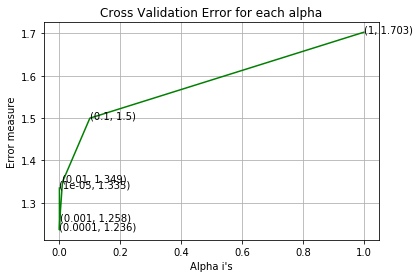

For values of best alpha =  0.0001 The train log loss is: 0.6626240674468347
For values of best alpha =  0.0001 The cross validation log loss is: 1.2358888954227938
For values of best alpha =  0.0001 The test log loss is: 1.2425616857238477


In [47]:
# Train a Logistic regression+Calibration model using text features whicha re on-hot encoded
alpha = [10 ** x for x in range(-5, 1)]


cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


<p style="font-size:18px;"> <b>Q.</b> Is the Text feature stable across all the data sets (Test, Train, Cross validation)?</p>
<p style="font-size:16px;"> <b>Ans.</b> Yes, it seems like! </p>

<font color="purple" size=4>Result of Univariate analysis
    - Text gives least cv loss and test loss,in comparision to random model,So,Its most important,then Gene then Variation

In [48]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [49]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

96.607 % of word of test data appeared in train data
98.253 % of word of Cross Validation appeared in train data


## Data Preparation

In [51]:
#Data preparation for ML models.

#Misc. functionns for ML models


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [52]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

<p style="font-size:24px;text-align:Center"> <b>Stacking the three types of features </b><p>

In [66]:
# merging gene, variance and text features

# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))


## BaseLine Model

### Naive Bayes
    - Hyperparameter Tuning

In [80]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.3070467482048003
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.2963960559428669
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.276558794235274
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.2744887681153019
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.2833529000466695
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.3894344945499357
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.3638981469127625
Alpha=  [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]
LOg-loss: 1.339437793402316


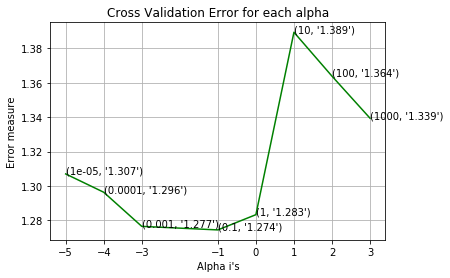

For values of best alpha =  0.1 The train log loss is: 0.8506374619600374
For values of best alpha =  0.1 The cross validation log loss is: 1.2744887681153019
For values of best alpha =  0.1 The test log loss is: 1.3155465722017656


In [67]:
from sklearn.naive_bayes import MultinomialNB

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []

for i in alpha:
    print("Alpha= ",alpha)
    clf=MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf=CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotCoding,train_y)
    sig_clf_probs=sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs))
    print("LOg-loss:",log_loss(cv_y,sig_clf_probs))
    
    
    
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))



Log Loss : 1.2744887681153019
Number of missclassified point : 0.39849624060150374
-------------------- Confusion matrix --------------------


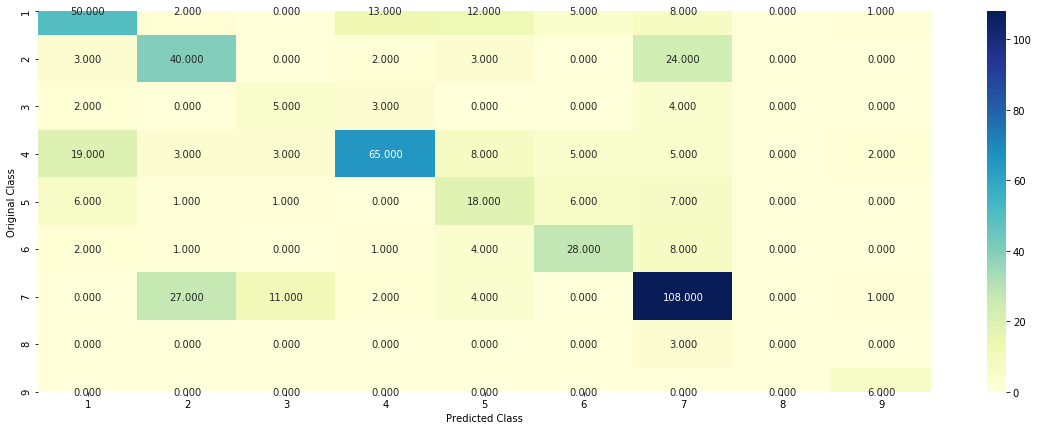

-------------------- Precision matrix (Columm Sum=1) --------------------


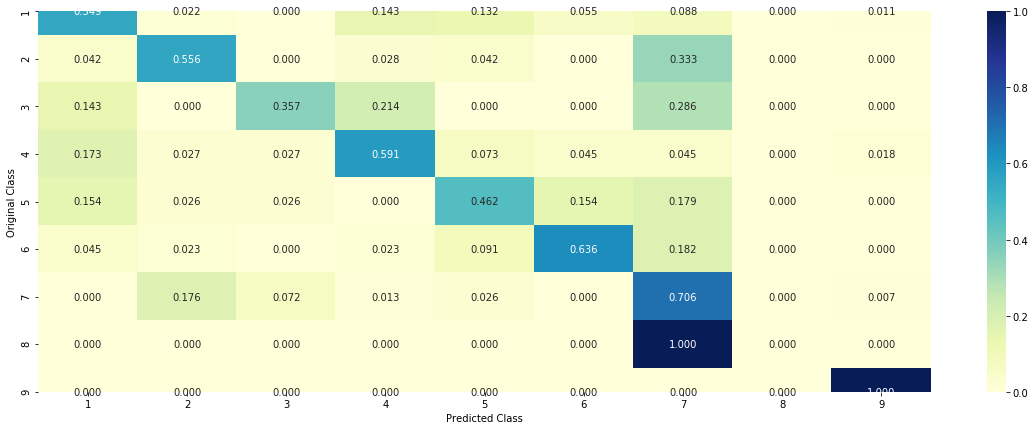

-------------------- Recall matrix (Row sum=1) --------------------


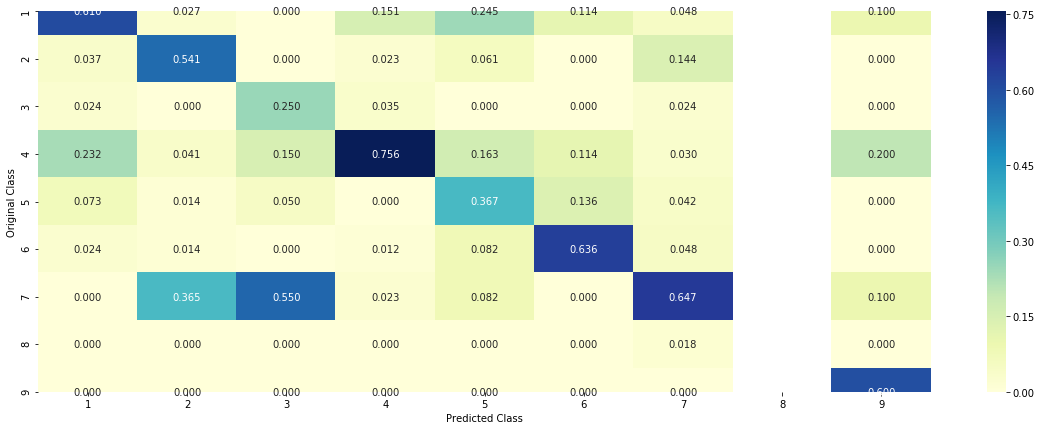

In [68]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

In [79]:
test_point_index = 99
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[1.720e-02 8.000e-04 0.000e+00 9.677e-01 2.000e-04 1.000e-04 2.200e-03
  9.600e-03 2.200e-03]]
Actual Class : 4
--------------------------------------------------
164 Text feature [activating] present in test data point [True]
176 Text feature [lys] present in test data point [True]
181 Text feature [harboring] present in test data point [True]
270 Text feature [novel] present in test data point [True]
306 Text feature [kinase] present in test data point [True]
308 Text feature [modeling] present in test data point [True]
331 Text feature [precipitate] present in test data point [True]
343 Text feature [suppressor] present in test data point [True]
356 Text feature [degrons] present in test data point [True]
359 Text feature [potential] present in test data point [True]
367 Text feature [recently] present in test data point [True]
373 Text feature [659] present in test data point [True]
380 Text feature [sequenced] present in test dat

## Logistic regression

for alpha = 1e-06
Log Loss : 1.4089687915015932
for alpha = 1e-05
Log Loss : 1.3740789735479653
for alpha = 0.0001
Log Loss : 1.2231336452692645
for alpha = 0.001
Log Loss : 1.214175695485529
for alpha = 0.01
Log Loss : 1.2792575828917088
for alpha = 0.1
Log Loss : 1.5141506030895497
for alpha = 1
Log Loss : 1.7012367267351098
for alpha = 10
Log Loss : 1.7243864723461853
for alpha = 100
Log Loss : 1.7267736549096322


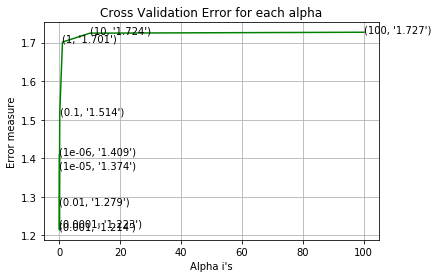

For values of best alpha =  0.001 The train log loss is: 0.525889881367281
For values of best alpha =  0.001 The cross validation log loss is: 1.214175695485529
For values of best alpha =  0.001 The test log loss is: 1.160571901158568


In [74]:


alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Log loss : 1.214175695485529
Number of mis-classified points : 0.37593984962406013
-------------------- Confusion matrix --------------------


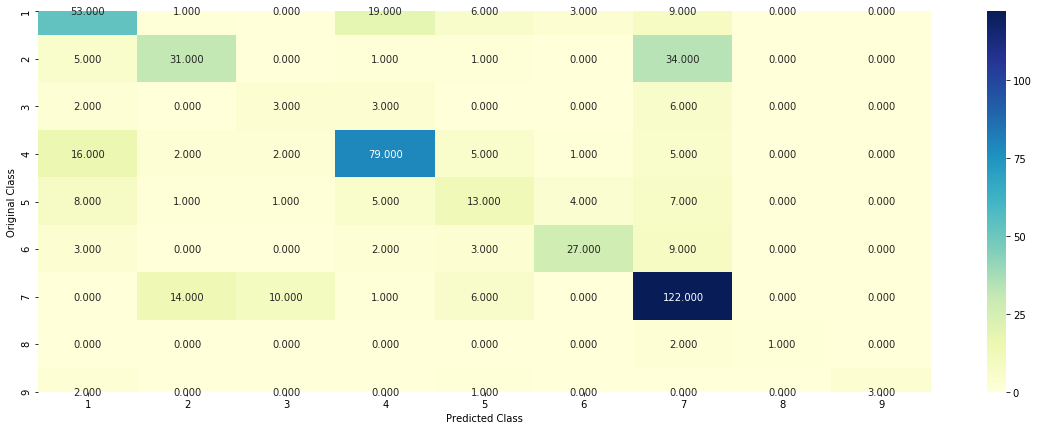

-------------------- Precision matrix (Columm Sum=1) --------------------


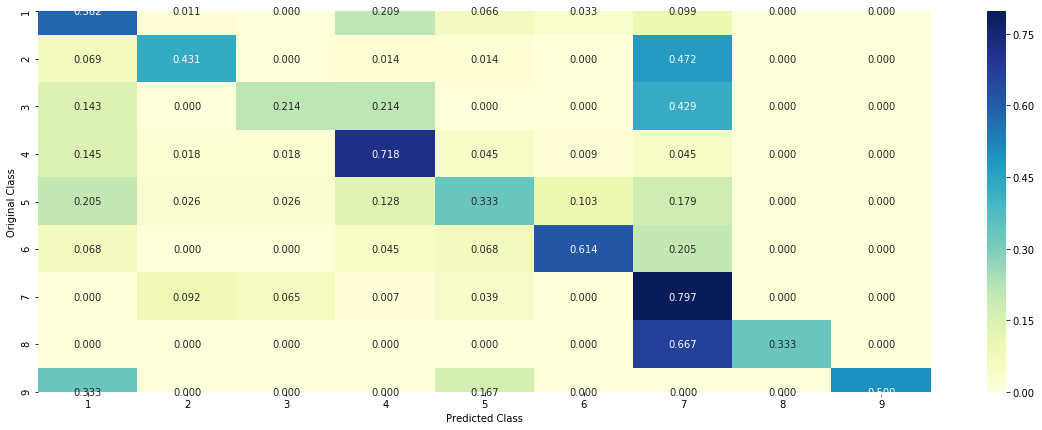

-------------------- Recall matrix (Row sum=1) --------------------


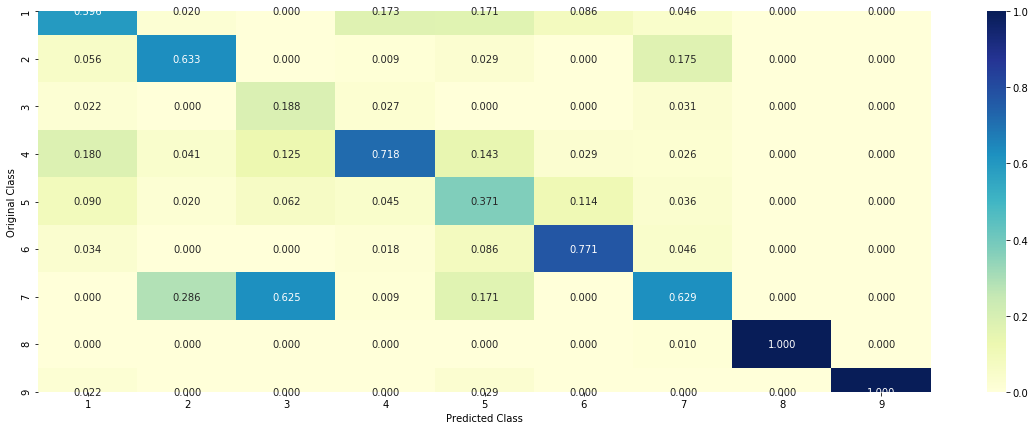

In [75]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

In [77]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [78]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.4243 0.0455 0.0032 0.4141 0.0141 0.0202 0.0661 0.006  0.0067]]
Actual Class : 6
--------------------------------------------------
191 Text feature [kinase] present in test data point [True]
353 Text feature [inhibitors] present in test data point [True]
359 Text feature [mori] present in test data point [True]
385 Text feature [inhibitor] present in test data point [True]
401 Text feature [active] present in test data point [True]
431 Text feature [expressing] present in test data point [True]
433 Text feature [louis] present in test data point [True]
488 Text feature [baculoviral] present in test data point [True]
Out of the top  500  features  8 are present in query point


## Submission

In [81]:
csvs=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\Datasets\cancer treatment\\ss.csv')

In [125]:
csvs.tail()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
981,982,0,0,0,0,0,0,0,0,0
982,983,0,0,0,0,0,0,0,0,0
983,984,0,0,0,0,0,0,0,0,0
984,985,0,0,0,0,0,0,0,0,0
985,986,0,0,0,0,0,0,0,0,0


In [84]:
pred=clf.predict(test_x_onehotCoding)

In [86]:
from sklearn.metrics import accuracy_score

In [87]:
tr_text=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\\Datasets\\cancer treatment\\training_text\\training_text',sep='\|\|',engine="python",names=["ID","TEXT"],skiprows=1)
tr_var=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\\Datasets\\cancer treatment\\training_variants\\training_variants',error_bad_lines=False)
# error bad lines now not required because ,sepeator was the issue


0.6556390977443609

In [118]:
predte_text=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\\Datasets\\cancer treatment\\test_text\\test_text',sep='\|\|',engine="python",names=["ID","TEXT"],skiprows=1)
te_var=pd.read_csv('C:\\Users\\Sourabh\\AppliedAI\\Datasets\\cancer treatment\\test_variants\\test_variants')
# error bad lines now not required because ,sepeator was the issue


In [119]:
predte_text.head()

,ID,TEXT
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [120]:
te_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


In [124]:
len(predte_text)

5668